# Modeling Magnetic Anomalies

In this section we discuss how to solve PDE for magnetic field anomalies due to a variation of
the magnetic susceptibility in the subsurface using `esys.escript`. It is assumed that you have 
worked through the [introduction section on `esys.escript`](escriptBasics.ipynb). 
First we will provide the basic theory:

## Theoretical Background
The observed magnetic field results $\mathbf{B}_t$ from the interaction
between the Earth's background field $\mathbf{B}_b$ and the magnetisation $\mathbf{M}$. 
Under the assumption of a small magnetisation the  
magnetisation is given as 
\begin{equation} 
\mathbf{M} = k \mathbf{B}_b
\end{equation}
where $k \ge 0$ is the magnetic susceptibility. 
The magnetisation induces a total magnetic field $\mathbf{B}_t$ which can be decomposed in the background field $\mathbf{B}_b$ and 
the magenetic anomaly field $\mathbf{B}_a$:
\begin{align} 
\mathbf{B}_t & = \mathbf{B}_H + \mathbf{B}
\end{align}
In the SI system $\mathbf{B}$ has the units is in Tesla $T$. The Earth's background field $\mathbf{B}_H$ varies between $25,000$ and $65,000 nT$ ($nT = 10^{-9} T $ referes to *nano Tesla*) 

The total magnetic field anomaly $b_a$ is the difference of the intensity of the 
total magnetic field $\mathbf{B}$ and of the background field $\mathbf{B}_H$: 
\begin{equation} 
b_a=|\mathbf{B}_t|-|\mathbf{B}_b| 
\end{equation}
where in 2D
\begin{equation} 
|\mathbf{B}| = \sqrt{B_x^2 + B_z^2} \mbox{ if }  \mathbf{B}=(B_x, B_z)
\end{equation}
The total magnetic field anomaly $b_a$ is what is measured in the field.
The Gauss's law for magnetism states that the magnetic flux $\mathbf{B_F}=\mathbf{B}_t+\mathbf{M}$
is divergence free:
\begin{equation} 
\nabla^t \mathbf{B_F} = 0
\end{equation}
Assuming that $\nabla^t \mathbf{B}_b=0$ this simplifies to  
\begin{equation} \label{EQGAUSS}
\nabla^t  (\mathbf{B} + k \mathbf{B}_b )  = 0
\end{equation}
Analogously to gravity one can introduce a scalar potential $U$ with 
\begin{equation} \label{EQPOTENTIAL}
\mathbf{B} = - \nabla U = (-\frac{\partial U}{\partial x}, -\frac{\partial U}{\partial z})
\end{equation}
in the 2D case. Equations \eqref{EQGAUSS} and \eqref{EQPOTENTIAL} form a PDE for the scalar potential $U$.

## In the `esys.escript` form

Recall the `esys.escript` PDE template: When $u$ is the unknown
the `flux` vector $\mathbf{F}$ is defined as 
\begin{equation} \label{EQFLUX}
\mathbf{F} = - \mathbf{A} \mathbf{\nabla} u +\mathbf{X}
\end{equation} 
with some matrix $\mathbf{A}$ and some vector $\mathbf{X}$. Then the flux vector $\mathbf{F}$ needs to fulfill the conservation equation : 
\begin{equation}\label{EQCONSERVATION}
\mathbf{\nabla}^t \; \mathbf{F} + D \; u = Y 
\end{equation}
where $D$ is a scalar and $Y$ is the right hand side. 

We identify the flux $\mathbf{F}$ from \eqref{EQGAUSS} as $\mathbf{B} + k \mathbf{B}_b$ which gives 
with \eqref{EQPOTENTIAL}
\begin{equation} \label{EQFLUX2}
\mathbf{F} = -  \mathbf{\nabla} U +k \mathbf{B}_b
\end{equation} 
from which we see that we need to choose 
$\mathbf{A}$ as the identity matrix and $\mathbf{X}=k \mathbf{B}_b$ (that is the magnetization). 
In this case it is $D=0$ and $Y=0$.

###### Problem 

For a domain of $2 \times 2 km$ we want to model the total magnetic field anomaly $b_a$ over a horizontal 
transect. The transect is located at a height of $H_0=1200m$ above the bottom edge of the domain and
is assumed to define the surface of the Earth. 
The magnetic anomaly is produced by a vertical dyke of width $w=60m$ where the top end 
of the dyke is located at a depth $D=100m$ below the surface along the vertical center line of the domain
(at $x_0=500m$). It is assumed that a 2D model is sufficient.
Of particular interest is the question how the total magnetic field response of the dyke 
would eb different at the North Pole, the South Pole and the equator.

<img src="./IMAGE_Dyke.jpg">



In [1]:
dx=8        # grid line spacing in [m]
NEx=250 
NEz=250
H0=1200       # height [m] of transect above bottom of domain (will be locked to grid)
b_b=45000.0  # intensity of the background magnetic field in nT
ksi=0.015    # assumed susceptibility
D=100
w=60

%matplotlib notebook

## Domain and Transect Set-up

Before we can do any modeling we need to set up the domain. This analogously to the gravity case.

In [2]:
from esys.escript import *
from esys.finley import Rectangle

Lx=dx*NEx
Lz=dx*NEz
print("Domain dimension = %g x %g m"%(Lx, Lz))

domain=Rectangle(n0=NEx, n1=NEz, l0=Lx, l1=Lz)

Domain dimension = 2000 x 2000 m


Here we also define the `Locator` to pick the values for the total magnetic field anomaly $b_a$  from a 
`Data` object. Again we first create the offsets along the transect.

In [3]:
x0_transect=np.linspace(0., Lx, NEx)

We then add the appropriate $x_1$ coordinate (=`H0`) to build up the 2D coordinates in the domain: 

In [4]:
x_transect=[ (x0, H0) for x0 in x0_transect]

Now we are ready to create the `Locator` named `transect_locator` which we later to fetch the values 
of the total magnetic field anomaly $b_a$ for the transect. We will calculate $b_a$ at element centers 
indicated by the argument `where=ReducedFunction(domain)`:

In [5]:
from esys.escript.pdetools import Locator
transect_locator=Locator(where=ReducedFunction(domain), x=x_transect )

As `transect_locator` could have moved the requested point `x_transect` locations toward 
element centers but we want to use these locations later for plotting $b_a$ over the profile we
obtain the actually used $x_0$-coordinates (=offset within the transect):

In [6]:
x0_transect=[ x[0] for x in transect_locator.getX()]

## Setup the PDE

Now we are ready to set up the PDE we need to solve to obtain the scalar potential $U$ for the 
magnetic field anomaly $\mathbf{B}$:

In [7]:
from esys.escript.linearPDEs import LinearSinglePDE

model=LinearSinglePDE(domain)

The easy bit is to `A`. It is the same as in the gravity case: 

In [8]:
model.setValue(A=identityTensor(domain))

Again we fix the potential to zero at the top and the bottom of the domain:

In [9]:
x=domain.getX()
q_bottom=whereZero(x[1])     # 1 for face x_1=0
q_top=whereZero(x[1]-Lz)  # 1 for face x_1=Lz

model.setValue(q=q_bottom+q_top)

The magnetic anomaly is defined as product of the 
background magnetic field $\mathbf{B}_b$ 
and the susceptibility $k$. This is the magnetization which in fact becomes the value for $\mathbf{X}$
in the PDE template.

We start with susceptibility $k$. We want to have the ksi
for locations with an $x_1$ lower than $H_0-D$ where $H_0$ is the surface location
above the bottom of the domain and $D$ is the depth of the top edge of the dyke below the surface. 
Again we use the `whereNegative` to set this up. This time we define the susceptibility at the center
of elements:

In [10]:
X=ReducedFunction(domain).getX()
m1=whereNegative(X[1]-(H0-D))

As second condition we want to have a positive susceptibility $k$ only for those location that are 
less then $\frac{w}{2}$ away from the central vertical line at $x_0=\frac{Lx}{2}$ that means 
that 
\begin{equation}
| x_0 -  \frac{Lx}{2} | < \frac{w}{2}
\end{equation}
which is implemented using the `whereNegative` once again: 

In [11]:
m2=whereNegative(abs(X[0]-Lx/2)-w/2)

The susceptibility $k$ is then set to:

In [12]:
k=ksi*m1*m2

Let's quickly check if we have done the right thing and plot the distribution of `k` with
`matplotlib`:

<IPython.core.display.Javascript object>


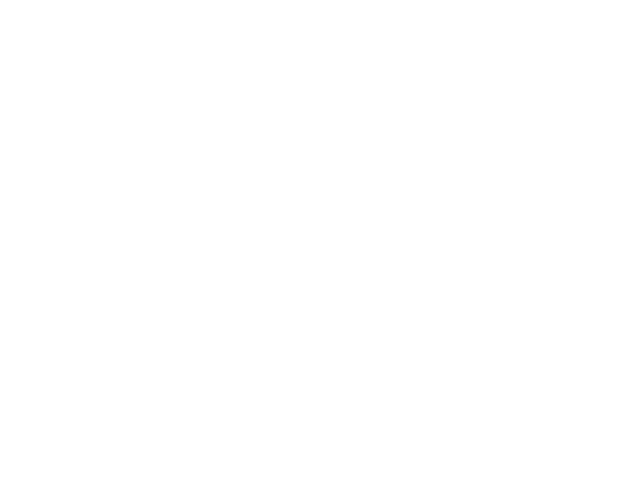

<IPython.core.display.Javascript object>


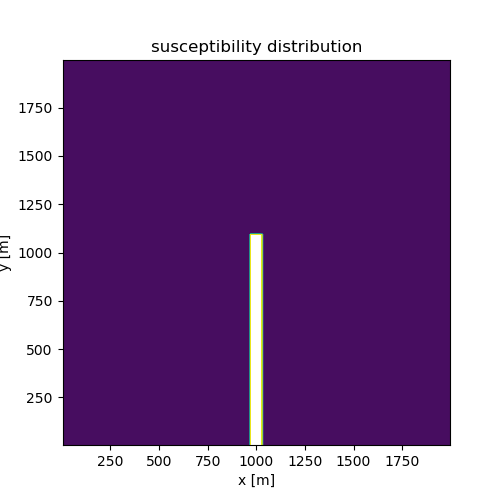

Text(0.5,1,'susceptibility distribution')

In [13]:
k_np=convertToNumpy(k)
x_np=convertToNumpy(k.getFunctionSpace().getX())

import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(5,5))
plt.tricontourf(x_np[0], x_np[1], k_np[0], 15)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("susceptibility distribution")

At the equator the background magnetic field has south-east orientation parallel to the surface of the Earth:
\begin{equation}\label{EQBBEquator}
\mathbf{B}_b=
\begin{bmatrix}
 -b_b \\
 0
\end{bmatrix}
\end{equation}
With this we can now set the coefficient `X`:

In [14]:
B_b=[-b_b, 0.]
model.setValue(X=k*B_b)

and get the scalar potential

In [15]:
u=model.getSolution()

Now we can get magenetic anomaly field $\mathbf{B}_a$ as the gradient of the scalar potential. Here we calculate
the gradient at the center of elements:

In [16]:
B_a=-grad(u, where=ReducedFunction(domain))

The total magnetic field anomaly $b_a$ is calculated and its values are picked along the transect:

In [17]:
b_a=length(B_a+B_b)-b_b
b_a_transect=transect_locator.getValue(b_a)

<IPython.core.display.Javascript object>


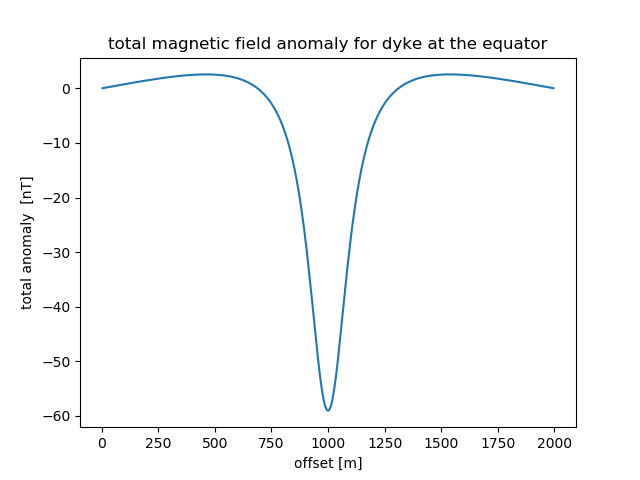

In [18]:
plt.figure()#figsize=(12,5))
plt.plot(x0_transect, b_a_transect)
plt.xlabel('offset [m]')
plt.ylabel('total anomaly  [nT]')
plt.title("total magnetic field anomaly for dyke at the equator")
plt.show()

## Total Magnetic Anomaly at the Poles

We want compare the total magnetic field anomaly $b_a$ we have just calculated 
for the equator with the one at the North Pole. 
To simplify the coding we write a function `getTotalMagneticFieldAnomaly` that takes a
background magnetic field and return the total magnetic field anomaly along the transect.

In [19]:
def getTotalMagneticFieldAnomaly(B_b):
    model.setValue(X=k*B_b)
    u=model.getSolution()
    B_a=-grad(u, where=ReducedFunction(domain))
    b_a=length(B_a+B_b)-sqrt(B_b[0]**2+B_b[1]**2)
    b_a_transect=transect_locator.getValue(b_a)
    return b_a_transect

<IPython.core.display.Javascript object>


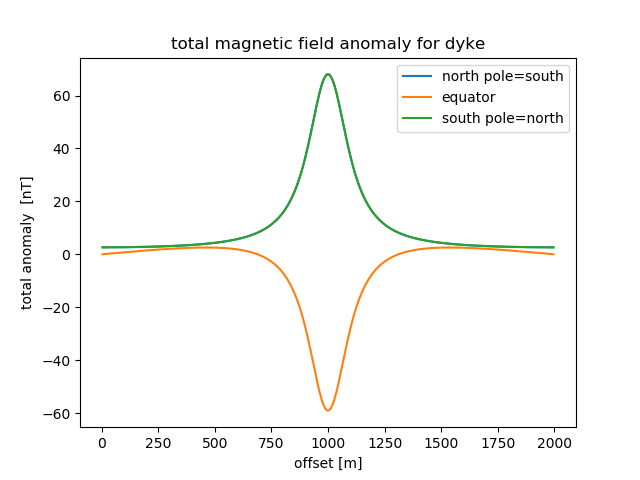

In [20]:
plt.figure()#figsize=(12,5))
plt.plot(x0_transect, getTotalMagneticFieldAnomaly(B_b=[0, -b_b]), label="north pole=south")
plt.plot(x0_transect, getTotalMagneticFieldAnomaly(B_b=[-b_b, 0.]), label="equator")
plt.plot(x0_transect, getTotalMagneticFieldAnomaly(B_b=[0, b_b]), label="south pole=north")
plt.xlabel('offset [m]')
plt.ylabel('total anomaly  [nT]')
plt.title("total magnetic field anomaly for dyke")
plt.legend()
plt.show()